In [22]:
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,DataCollatorWithPadding, AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, BertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset as HFDataset, load_metric
from datasets import load_dataset
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
wandb.login()

True

In [24]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

In [25]:
# Create a custom PyTorch Dataset
class EncodedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [26]:
from torch.optim import RAdam, AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup, \
    get_cosine_with_hard_restarts_schedule_with_warmup, get_constant_schedule_with_warmup

# Choose optimizer and learning rate scheduler
def getOptimizer(model, total_train_steps, scheduler_type="linear",
                  lr=1e-4, weight_decay=0.01, warmup_steps=0):
    
    optimizer = AdamW(params=model.parameters(), lr=float(lr), weight_decay=weight_decay)
    
    if scheduler_type == "linear":
        lr_scheduler = get_linear_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_train_steps
        )
    elif scheduler_type == "cosine":
        lr_scheduler = get_cosine_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_train_steps
        )
    else:
        lr_scheduler = get_constant_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=warmup_steps
        )

    return optimizer, lr_scheduler

In [27]:
do_label_same_size_sample = False
predict_only_one = False
label_to_avoid_predict = "Contrato"

# DISTILLBERT TIMESPLIT

In [28]:
# Load data 
dataFrame = pd.read_csv('digitalizações_registadas.csv', 
                       delimiter=";",
                       date_format="", 
                       parse_dates=['Data Emissão','Data vencimento indicada',"Data entrada"]) 

# Strip any leading or trailing whitespace from column names
dataFrame.columns = dataFrame.columns.str.strip()

# Get unnamed columns to remove
unnamed_columns = [col for col in dataFrame.columns if col.startswith('Unnamed')]

# Drop unnamed columns
dataFrame = dataFrame.drop(columns=unnamed_columns)

# Drop rows with any null values
dataFrame = dataFrame.dropna(subset=['Data vencimento indicada','Data Emissão','Origem']) #'Contrato'

# Convert columns to date type
dataFrame['Data entrada'] = pd.to_datetime(dataFrame['Data entrada'], format="%d/%m/%Y")
#dataFrame['Data Emissão'] = pd.to_datetime(dataFrame['Data Emissão'], format="%d/%m/%Y")
#dataFrame['Data vencimento indicada'] = pd.to_datetime(dataFrame['Data vencimento indicada'], format="%d/%m/%Y")



In [29]:
# Since we only want to predict Contrato or Manual, we discard rows with Requisição
dataFrame = dataFrame[dataFrame['Origem'] != "Requisição"]

# Set Labels column (this is unecessary as we can use Origem - but good for readability)
dataFrame['Labels'] = dataFrame['Origem']

In [30]:
if do_label_same_size_sample:
    grouped = dataFrame.groupby('Labels')
    min_size = grouped.size().min()
    dataFrame = grouped.apply(lambda x: x.sample(min_size)).reset_index(drop=True)

In [31]:
feature_columns = ["Fornecedor","Data Emissão","Data entrada","Data vencimento indicada", "Valor com IVA"]
# Function to format the row data
def format_row(row, feature_columns, dataframe):
    parts = []
    for column in feature_columns:
        value = row[column]
        if pd.api.types.is_datetime64_any_dtype(dataframe[column]):
            value = value.strftime('%d/%m/%Y')
        parts.append(f"{column}: {value}")
    return '\n '.join(parts) + "\n"


def buildDocRepresentation(dataframe, feature_columns):
    dataframe['FullText'] = dataframe.apply(lambda row: format_row(row, feature_columns, dataframe), axis = 1)


buildDocRepresentation(dataFrame, feature_columns)

In [32]:
# Build column with doc text representation
dataFrame['FullText'] = (
"Fornecedor:"+dataFrame['Fornecedor'] 
+ '\n Data emissão:' + dataFrame['Data Emissão']  
+ '\n Data entrada:' + dataFrame['Data entrada'].dt.strftime('%d/%m/%Y')
+ '\n Data vencimento:' + dataFrame['Data vencimento indicada']
+ "\n Valor com IVA:"+dataFrame["Valor com IVA"]
+ "\n"
)

In [33]:
# Init label encoder
label_encoder = LabelEncoder()

# Perform timesplit - we train on older samples and test on recent ones
dataFrame_before_2024 = dataFrame[dataFrame['Data entrada'] < '2024-02-01']
dataFrame_after_2024 = dataFrame[dataFrame['Data entrada'] >= '2024-02-01']

if predict_only_one:
    dataFrame_after_2024 = dataFrame_after_2024[dataFrame_after_2024['Labels'] != label_to_avoid_predict]


# Especify what is train/test for readability
train_texts = dataFrame_before_2024['FullText'].tolist()
test_texts = dataFrame_after_2024['FullText'].tolist()
train_labels = dataFrame_before_2024['Labels'].tolist()
test_labels = dataFrame_after_2024['Labels'].tolist()

# Encode labels - model cant take actual text - we need to encode text to numbers
encoded_labels_train = label_encoder.fit_transform(train_labels)
encoded_labels_test = label_encoder.fit_transform(test_labels)

In [34]:
# Count Contrato rows and Manual rows
count_contrato = dataFrame_before_2024['Labels'].value_counts().get('Contrato', 0)
count_manual = dataFrame_before_2024['Labels'].value_counts().get('Manual', 0)
print(count_contrato)
print(count_manual)

3415
23323


In [35]:
# Check classes/labels
list(label_encoder.classes_)

['Contrato', 'Manual']

In [36]:
# Initialize our tokenizer - SHOULD MATCH OUR CHOSEN MODEL!
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Add special tokens if necessary: in this case we add a PAD token
# to pad our input bc they must have the same length
special_tokens_dict = {"pad_token": "<PAD>"}
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens(special_tokens_dict)

loading file vocab.txt from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading configuration file config.json from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,


In [37]:
# Encode our document text representations
encodings_train = tokenizer(train_texts, truncation=True, padding=True, max_length=128 )
encodings_test = tokenizer(test_texts, truncation=True, padding=True, max_length=128 )

In [38]:
# Initialize our encoded pytorch datasets
train_dataset = EncodedDataset({'input_ids': encodings_train['input_ids'], 
                                'attention_mask': encodings_train['attention_mask']}, 
                                encoded_labels_train)

val_dataset = EncodedDataset({'input_ids': encodings_test['input_ids'],
                               'attention_mask': encodings_test['attention_mask']},
                                 encoded_labels_test)

In [39]:
# Initialize DataLoaders - responsible for building and preparing the batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

In [40]:
configs = [
    {
    "runName":"distillbert-mps-timesplit",
    "lr":1e-4,
    "epochs":1,
    "weight_decay":0.01,
    "save":False,
    "scheduler_type":"cosine",
    "warmup_steps":100
    },   
]

In [41]:
for conf in configs:
    # Instantiate the model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))  # Adjust num_labels as needed

    # move model to device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    # Calculate total train steps for scheduler
    num_training_steps = len(train_loader) * conf['epochs']

    # Init optimizer and scheduler
    optimizer, scheduler = getOptimizer(model, num_training_steps, scheduler_type=conf['scheduler_type'],
                                        lr=conf['lr'], weight_decay=conf['weight_decay'],
                                        warmup_steps=conf['warmup_steps'])

    # Define the loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    model.train()
    train_losses = []
    steps = 0

    # Wandb init conf
    runName = f"experiment_{conf['runName']}"
    run = wandb.init(
        project="cob-demo",
        name=runName, 
        config={
            "learning_rate": conf['lr'],
            "epochs": conf['epochs'],
            "weight_decay":conf['weight_decay'],
            "scheduler_type":conf['scheduler_type'],
            "warmup_steps":conf['warmup_steps']
        },
    )

    # Train model
    for epoch in range(conf['epochs']):
        epoch_train_loss = 0.0
        for batch in train_loader:
            steps += 1

            # get inputs
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # forward inputs through model
            outputs = model(input_ids, attention_mask)
            # calculate loss
            loss = criterion(outputs.logits, labels)
            # perform backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            epoch_train_loss += loss.item()
            wandb.log({"loss": loss.item(), "step":steps, "learning_rate":scheduler.get_last_lr()[0]})


        # Calculate average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        
        print(f"Run: {conf['runName']}   |Epoch {epoch + 1}, Train Loss: {epoch_train_loss}")


    # Evaluate model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_losses = []
    val_accuracies = []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
                
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    
    print(f"Validation Loss: {val_loss}, Accuracy: {accuracy}%")
    

    report = classification_report(y_true, y_pred, output_dict=True)
    print("Classification Report:")
    print(report)

    wandb.run.summary["report"] = report
    wandb.finish()
    if conf['save']:
        model.save_pretrained("distillbert/"+runName)


loading configuration file config.json from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.0",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequ

Run: distillbert-mps-timesplit   |Epoch 1, Train Loss: 0.17548540096983992
Validation Loss: 0.1847387985530289, Accuracy: 93.30889092575619%
Classification Report:
{'0': {'precision': 0.5941043083900227, 'recall': 0.6986666666666667, 'f1-score': 0.6421568627450981, 'support': 375.0}, '1': {'precision': 0.9711955136375223, 'recall': 0.9551265981448984, 'f1-score': 0.9630940343781598, 'support': 3989.0}, 'accuracy': 0.9330889092575618, 'macro avg': {'precision': 0.7826499110137726, 'recall': 0.8268966324057825, 'f1-score': 0.8026254485616289, 'support': 4364.0}, 'weighted avg': {'precision': 0.9387919384844948, 'recall': 0.9330889092575618, 'f1-score': 0.9355157943776102, 'support': 4364.0}}


learning_rate,▂▃▄▅▇██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
loss,█▄▅▅▇▄▃▂▄▁▂▂▁▂▁▂▂▃▂▄▃▂▂▂▂▁▂▁▁▁▂▃▂▂▂▂▂▃▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,0.0
loss,0.10013
step,836


In [42]:
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       375
           1       0.97      0.96      0.96      3989

    accuracy                           0.93      4364
   macro avg       0.78      0.83      0.80      4364
weighted avg       0.94      0.93      0.94      4364



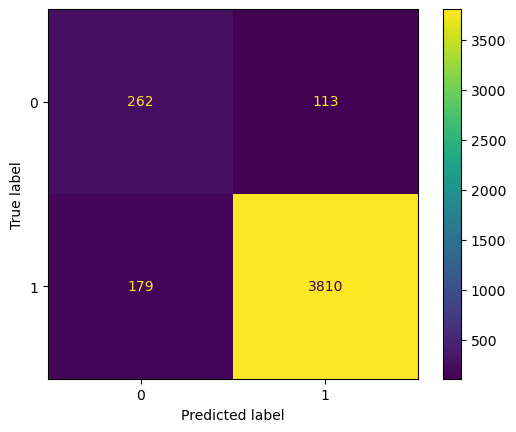

In [44]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distillbert/") 

In [ ]:
# Function to make predictions on new data
def predict(texts):
    # Tokenize the input texts
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
    
    # Move the model to the correct device (CPU or GPU)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    encodings = {key: val.to(device) for key, val in encodings.items()}

    # Make predictions
    with torch.no_grad():
        outputs = model(**encodings)
    
    # Get the predicted class labels
    predictions = torch.argmax(outputs.logits, dim=-1)
    
    return predictions.cpu().numpy()

In [ ]:
texts = ["""

"""]
print(predict(texts))

In [ ]:
# Example usage
new_texts = [
    """

"""
    
]

predicted_labels = predict(new_texts)
print(predicted_labels)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Function to plot weight distributions
def plot_weight_distributions(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.extend(param.cpu().detach().numpy().flatten())

    plt.figure(figsize=(10, 6))
    sns.histplot(weights, bins=100, kde=True)
    plt.title('Distribution of Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot weight magnitude by layer
def plot_weight_magnitude_by_layer(model):
    layer_names = []
    weight_magnitudes = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            layer_names.append(name)
            weight_magnitudes.append(param.abs().mean().item())

    plt.figure(figsize=(12, 6))
    plt.barh(layer_names, weight_magnitudes)
    plt.title('Average Absolute Weight Magnitude by Layer')
    plt.xlabel('Average Absolute Weight Magnitude')
    plt.ylabel('Layer')
    plt.show()

# Function to plot attention weights
def plot_attention_weights(model):
    # Get the attention weights from the first layer (example)
    attention_weights = model.distilbert.transformer.layer[0].attention.q_lin.weight.detach().cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, cmap='viridis')
    plt.title('Attention Weights from First Layer')
    plt.xlabel('Head')
    plt.ylabel('Weight Index')
    plt.show()

# Plotting the distributions
plot_weight_distributions(model)
plot_weight_magnitude_by_layer(model)
plot_attention_weights(model)

# DISTILLBERT NORMAL SPLIT

In [45]:
# Load data 
dataFrame = pd.read_csv('digitalizações_registadas.csv', #'mdados_docs_cob.csv' mdados_docs_all_16k.csv
                       delimiter=";",
                       date_format="", 
                       parse_dates=['Data Emissão','Data vencimento indicada',"Data entrada"])  #, parse_dates=['DataEmissao']

# Strip any leading or trailing whitespace from column names
dataFrame.columns = dataFrame.columns.str.strip()

# Get unnamed columns to remove
unnamed_columns = [col for col in dataFrame.columns if col.startswith('Unnamed')]

# Drop unnamed columns
dataFrame = dataFrame.drop(columns=unnamed_columns)

# Drop rows with any null values
dataFrame = dataFrame.dropna(subset=['Data vencimento indicada','Data Emissão','Origem']) #'Contrato'

dataFrame['Data entrada'] = pd.to_datetime(dataFrame['Data entrada'], format="%d/%m/%Y")


In [46]:
dataFrame = dataFrame[dataFrame['Origem'] != "Requisição"]
dataFrame['Labels'] = dataFrame['Origem']

In [47]:
dataFrame['FullText'] = (
"Fornecedor:"+dataFrame['Fornecedor'] 
+ '\n Data emissão:' + dataFrame['Data Emissão']  
+ '\n Data entrada:' + dataFrame['Data entrada'].dt.strftime('%d/%m/%Y')
+ '\n Data vencimento:' + dataFrame['Data vencimento indicada']
+ "\n Valor com IVA:"+dataFrame["Valor com IVA"]
+ "\n"
)

In [48]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

special_tokens_dict = {"pad_token": "<PAD>"}
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens(special_tokens_dict)

loading file vocab.txt from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading configuration file config.json from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,


In [49]:
if predict_only_one:
    texts = dataFrame['FullText'].tolist()
    labels = dataFrame['Labels'].tolist()
else:
    # Assume the CSV has 'text' and 'label' columns
    texts = dataFrame['FullText'].tolist()
    labels = dataFrame['Labels'].tolist()

    # Encode labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128 )

    # Split dataset into training and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        encodings['input_ids'], encoded_labels, test_size=0.1, random_state=42
    )

    train_masks, val_masks = train_test_split(
        encodings['attention_mask'], test_size=0.1, random_state=42
    )

    train_dataset = EncodedDataset({'input_ids': train_texts, 'attention_mask': train_masks}, train_labels)
    val_dataset = EncodedDataset({'input_ids': val_texts, 'attention_mask': val_masks}, val_labels)

In [50]:
# DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

In [51]:
configs = [
    {
    "runName":"distillbert-mps-v1",
    "lr":1e-4,
    "epochs":1,
    "weight_decay":0.01,
    "save":False
    },   
]

In [52]:
for conf in configs:
    # Instantiate the model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))  # Adjust num_labels as needed

    # move model to device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)


    # Define the training arguments
    training_args = TrainingArguments(
    learning_rate=conf['lr'],
    output_dir='./results',          # output directory
    num_train_epochs=conf['epochs'],              # number of training epochs
    per_device_train_batch_size=32,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=conf['weight_decay'],               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    report_to="wandb",
    #fp16=True,
    use_mps_device=True,
    seed=seed,
    data_seed=seed
    )

    metric = load_metric("accuracy")

    def compute_metrics(p):
        return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)
    

    # Initialize the Trainer
    # may require the usage of model_init to ensure
    # reproducibility
    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

    wandb.init(project="cob-demo")
    wandb.run.name = conf['runName']

    # Train the model
    trainer.train()


    # Evaluate the model
    eval_result = trainer.evaluate()
    print(f"Evaluation results: {eval_result}")
    

    wandb.finish()
    if conf['save']:
        model.save_pretrained("distillbert/")


loading configuration file config.json from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.0",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /Users/rvlopes/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequ

/opt/homebrew/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 27991
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 875
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


  0%|          | 0/875 [00:00<?, ?it/s]

{'loss': 0.3955, 'learning_rate': 9.885714285714286e-05, 'epoch': 0.01}
{'loss': 0.4426, 'learning_rate': 9.771428571428572e-05, 'epoch': 0.02}
{'loss': 0.3691, 'learning_rate': 9.657142857142858e-05, 'epoch': 0.03}
{'loss': 0.3515, 'learning_rate': 9.542857142857143e-05, 'epoch': 0.05}
{'loss': 0.4336, 'learning_rate': 9.428571428571429e-05, 'epoch': 0.06}
{'loss': 0.2946, 'learning_rate': 9.314285714285715e-05, 'epoch': 0.07}
{'loss': 0.2392, 'learning_rate': 9.200000000000001e-05, 'epoch': 0.08}
{'loss': 0.2689, 'learning_rate': 9.085714285714286e-05, 'epoch': 0.09}
{'loss': 0.24, 'learning_rate': 8.971428571428571e-05, 'epoch': 0.1}
{'loss': 0.2538, 'learning_rate': 8.857142857142857e-05, 'epoch': 0.11}
{'loss': 0.2288, 'learning_rate': 8.742857142857144e-05, 'epoch': 0.13}
{'loss': 0.2665, 'learning_rate': 8.62857142857143e-05, 'epoch': 0.14}
{'loss': 0.2267, 'learning_rate': 8.514285714285714e-05, 'epoch': 0.15}
{'loss': 0.2007, 'learning_rate': 8.4e-05, 'epoch': 0.16}
{'loss': 0

Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json


{'loss': 0.1501, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.57}


Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json


{'loss': 0.1634, 'learning_rate': 4.1714285714285714e-05, 'epoch': 0.58}
{'loss': 0.1326, 'learning_rate': 4.057142857142857e-05, 'epoch': 0.59}
{'loss': 0.1238, 'learning_rate': 3.942857142857143e-05, 'epoch': 0.61}
{'loss': 0.1313, 'learning_rate': 3.8285714285714286e-05, 'epoch': 0.62}
{'loss': 0.1118, 'learning_rate': 3.7142857142857143e-05, 'epoch': 0.63}
{'loss': 0.117, 'learning_rate': 3.6e-05, 'epoch': 0.64}
{'loss': 0.1384, 'learning_rate': 3.485714285714286e-05, 'epoch': 0.65}
{'loss': 0.1288, 'learning_rate': 3.3714285714285716e-05, 'epoch': 0.66}
{'loss': 0.1708, 'learning_rate': 3.257142857142857e-05, 'epoch': 0.67}
{'loss': 0.1261, 'learning_rate': 3.142857142857143e-05, 'epoch': 0.69}
{'loss': 0.1332, 'learning_rate': 3.0285714285714288e-05, 'epoch': 0.7}
{'loss': 0.1391, 'learning_rate': 2.9142857142857146e-05, 'epoch': 0.71}
{'loss': 0.1599, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.72}
{'loss': 0.0973, 'learning_rate': 2.6857142857142857e-05, 'epoch': 0.73}


***** Running Evaluation *****
  Num examples = 3111
  Batch size = 16


  0%|          | 0/195 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 3111
  Batch size = 16


{'eval_loss': 0.13022200763225555, 'eval_accuracy': 0.944069431051109, 'eval_runtime': 9.2831, 'eval_samples_per_second': 335.126, 'eval_steps_per_second': 21.006, 'epoch': 1.0}
{'train_runtime': 281.1939, 'train_samples_per_second': 99.543, 'train_steps_per_second': 3.112, 'train_loss': 0.17003856883730206, 'epoch': 1.0}


  0%|          | 0/195 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.13022200763225555, 'eval_accuracy': 0.944069431051109, 'eval_runtime': 9.0468, 'eval_samples_per_second': 343.88, 'eval_steps_per_second': 21.555, 'epoch': 1.0}


eval/accuracy,▁▁
eval/loss,▁▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,▇▇█▄▄▅▃▃▂▂▁▂▃▃▂▂▂▂▂▃▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▂▂▂
train/total_flos,▁
train/train_loss,▁


In [53]:
preds = trainer.predict(val_dataset).predictions
preds = np.argmax(preds, axis=1)

***** Running Prediction *****
  Num examples = 3111
  Batch size = 16


  0%|          | 0/195 [00:00<?, ?it/s]

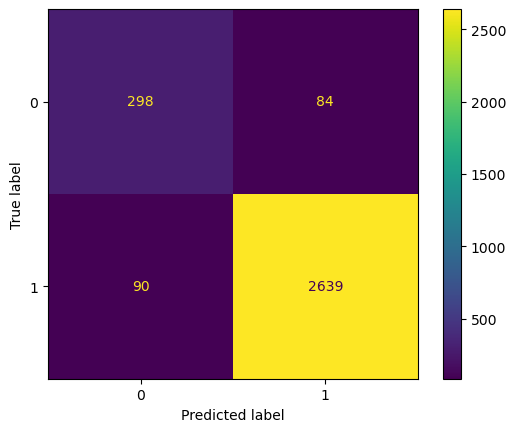

In [54]:
# Compute the confusion matrix
cm = confusion_matrix(val_labels, preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()